In [1]:
from mplmagic2 import svg

import functools
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.spatial.distance import cdist
import torch
import torch.nn.functional as F
from torch import optim
import pickle
from symfac.experimental import RBFExpansionPlus
from symfac.experimental import RBFExpansionMiniBatchPlus
from symfac.experimental.rbf_expansion_plugins import walltime
import timeit
import matplotlib.pyplot as plt
import pandas as pd
import json

In [2]:
target = torch.tensor(
    np.load('data/paper/QM7-rkhs-distance.maxdet.npy'),
    dtype=torch.float32
)

torch.Size([256, 256])


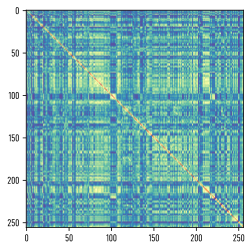

In [3]:
print(target.shape)
plt.imshow(target, cmap='Spectral')

In [4]:
N, _ = target.shape

# Walltime measurements

In [5]:
time_per_step = {}
batch_size_wall = 1024

100%|██████████| 2000/2000 [00:20<00:00, 96.53it/s]


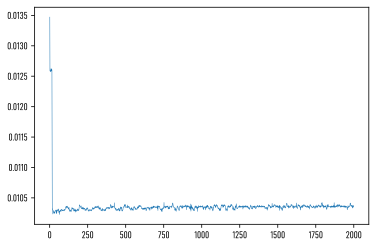

100%|██████████| 2000/2000 [00:37<00:00, 53.36it/s]


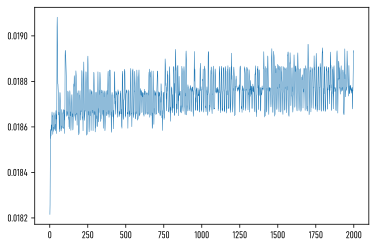

100%|██████████| 2000/2000 [00:54<00:00, 36.88it/s]


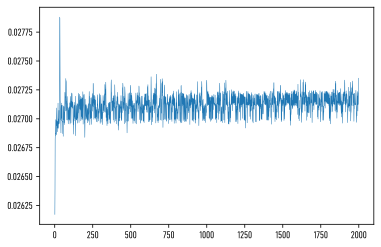

100%|██████████| 2000/2000 [01:05<00:00, 30.64it/s]


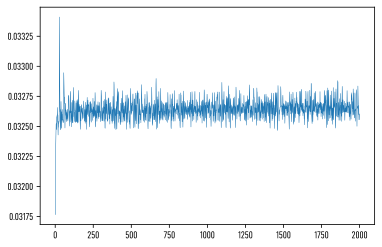

100%|██████████| 2000/2000 [01:22<00:00, 24.24it/s]


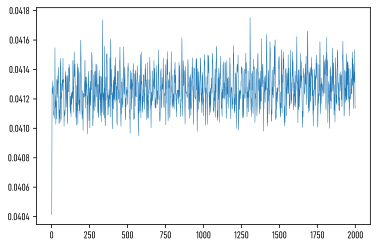

100%|██████████| 2000/2000 [01:34<00:00, 21.26it/s]


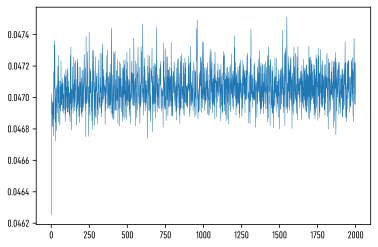

100%|██████████| 2000/2000 [01:50<00:00, 18.11it/s]


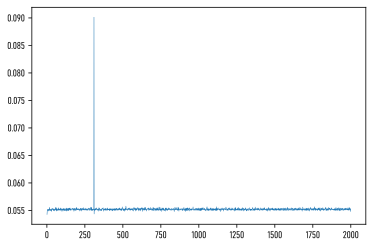

100%|██████████| 2000/2000 [02:03<00:00, 16.23it/s]


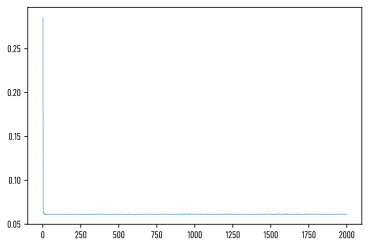

100%|██████████| 2000/2000 [02:20<00:00, 14.26it/s]


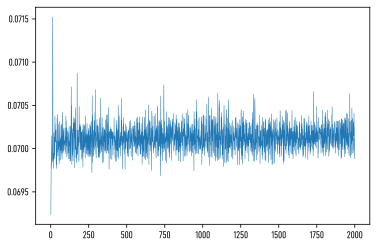

100%|██████████| 2000/2000 [02:31<00:00, 13.23it/s]


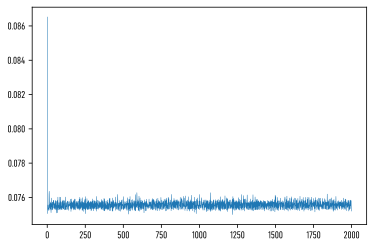

100%|██████████| 2000/2000 [04:00<00:00,  8.33it/s]


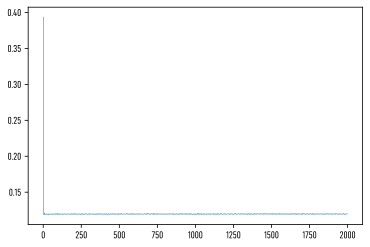

In [6]:
time_per_step['GD'] = table = {}

for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16]:
    num_iters = 2000
    start = timeit.timeit()
    fac = RBFExpansionPlus(
        k=k,
        batch_size=batch_size_wall,
        max_steps=num_iters
    )
    wall = []
    fac.fith(
        target,
        u0=1/10*torch.randn(batch_size_wall, len(target), k),
        a0=torch.randn(batch_size_wall, k),
        b0=torch.randn(batch_size_wall),
        plugins=[
            walltime(to=wall, every=1)
        ]
    )
    wall = pd.DataFrame(wall)
    dt = wall.time.diff()
    plt.plot(dt)
    plt.show()
    table[k] = dt.tail(1000).quantile(0.5)

In [7]:
time_per_step

{'GD': {1: 0.010356170999898495,
  2: 0.018769071000065196,
  3: 0.027150676000019303,
  4: 0.032652469499907966,
  5: 0.04127614599997287,
  6: 0.04706726799997796,
  7: 0.055211035000070297,
  8: 0.06141732100002173,
  9: 0.07012742749998324,
  10: 0.07557914349990824,
  16: 0.11964770300005512}}

  0%|          | 0/2000 [00:00<?, ?it/s]/home/symfac/SymFac/venv-mpl3.4/lib64/python3.8/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
100%|██████████| 2000/2000 [00:05<00:00, 348.08it/s]


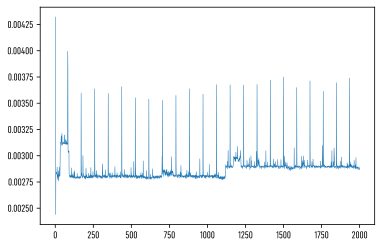

100%|██████████| 2000/2000 [00:06<00:00, 319.73it/s]


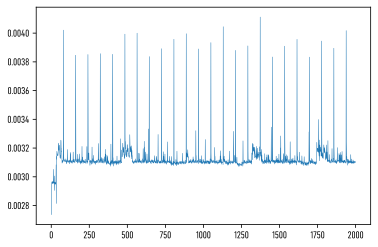

100%|██████████| 2000/2000 [00:06<00:00, 303.14it/s]


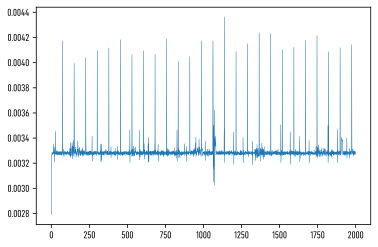

100%|██████████| 2000/2000 [00:07<00:00, 276.59it/s]


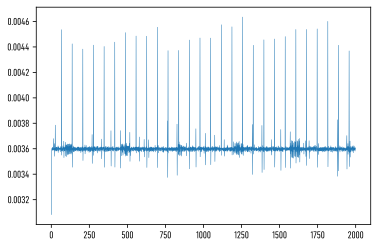

100%|██████████| 2000/2000 [00:07<00:00, 256.64it/s]


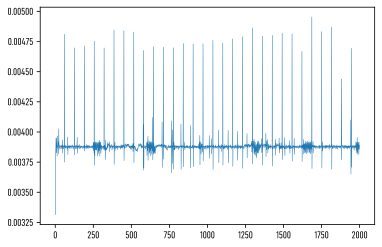

100%|██████████| 2000/2000 [00:08<00:00, 240.40it/s]


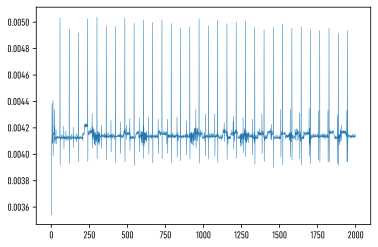

100%|██████████| 2000/2000 [00:08<00:00, 225.50it/s]


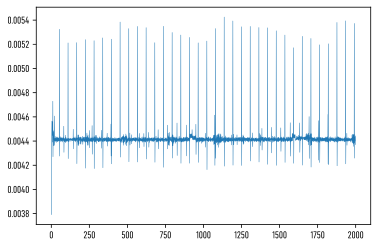

100%|██████████| 2000/2000 [00:09<00:00, 209.80it/s]


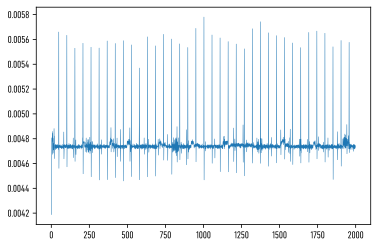

100%|██████████| 2000/2000 [00:10<00:00, 196.01it/s]


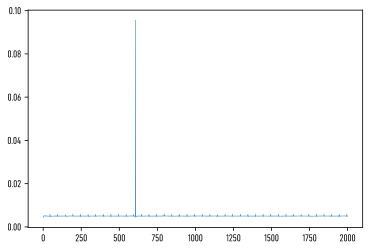

100%|██████████| 2000/2000 [00:10<00:00, 187.97it/s]


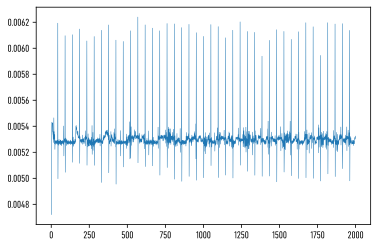

100%|██████████| 2000/2000 [00:14<00:00, 142.33it/s]


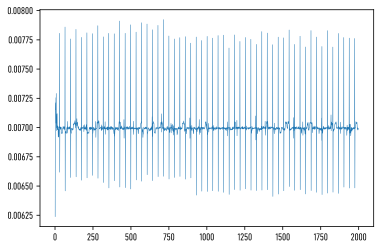

In [8]:
minibatch_multiplier = 8
batch_size_wall = 1024

time_per_step[f'SGD.MINIBATCH{minibatch_multiplier}'] = table = {}

for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 16]:
    num_iters = 2000
    start = timeit.timeit()
    fac = RBFExpansionMiniBatchPlus(
        mini_batch_size=N * minibatch_multiplier,
        k=k,
        batch_size=batch_size_wall,
        max_steps=num_iters,
        history_freq=10000
    )
    wall = []
    fac.fit_custom(
        target,
        f=lambda rbf, u, a, b:
            torch.sum(
                rbf(u[..., :, None, :] - u[..., None, :, :]) *
                a[..., None, None, :],
                dim=-1
            ) + b[..., None, None],
        f_minibatch=lambda rbf, i, j, u, a, b:
            torch.sum(
                rbf(u[..., i, :] - u[..., j, :]) * a[..., None, :],
            dim=-1
        ) + b[..., None],
        u=1/10*torch.randn(batch_size_wall, len(target), k),
        a=torch.randn(batch_size_wall, k),
        b=torch.randn(batch_size_wall),
        plugins=[
            walltime(to=wall, every=1)
        ]
    )
    wall = pd.DataFrame(wall)
    dt = wall.time.diff()
    plt.plot(dt)
    plt.show()
    table[k] = dt.tail(1000).quantile(0.5)

In [9]:
time_per_step

{'GD': {1: 0.010356170999898495,
  2: 0.018769071000065196,
  3: 0.027150676000019303,
  4: 0.032652469499907966,
  5: 0.04127614599997287,
  6: 0.04706726799997796,
  7: 0.055211035000070297,
  8: 0.06141732100002173,
  9: 0.07012742749998324,
  10: 0.07557914349990824,
  16: 0.11964770300005512},
 'SGD.MINIBATCH8': {1: 0.0028968785002234654,
  2: 0.0031054250000579486,
  3: 0.0032788099997560494,
  4: 0.0036005299998578266,
  5: 0.0038789539999015687,
  6: 0.004137956000022314,
  7: 0.004411385000139489,
  8: 0.004742534999877535,
  9: 0.005030798500001765,
  10: 0.005294907000006788,
  16: 0.006994879000103538}}

In [11]:
print(
    json.dumps({
        'GD': {
            1: 0.010356170999898495,
            2: 0.018769071000065196,
            3: 0.027150676000019303,
            4: 0.032652469499907966,
            5: 0.04127614599997287,
            6: 0.04706726799997796,
            7: 0.055211035000070297,
            8: 0.06141732100002173,
            9: 0.07012742749998324,
            10: 0.07557914349990824,
            16: 0.11964770300005512
        },
        'SGD.MINIBATCH8': {
            1: 0.0028968785002234654,
            2: 0.0031054250000579486,
            3: 0.0032788099997560494,
            4: 0.0036005299998578266,
            5: 0.0038789539999015687,
            6: 0.004137956000022314,
            7: 0.004411385000139489,
            8: 0.004742534999877535,
            9: 0.005030798500001765,
            10: 0.005294907000006788,
            16: 0.006994879000103538
        }
    })
)

{"GD": {"1": 0.010356170999898495, "2": 0.018769071000065196, "3": 0.027150676000019303, "4": 0.032652469499907966, "5": 0.04127614599997287, "6": 0.04706726799997796, "7": 0.055211035000070297, "8": 0.06141732100002173, "9": 0.07012742749998324, "10": 0.07557914349990824, "16": 0.11964770300005512}, "SGD.MINIBATCH8": {"1": 0.0028968785002234654, "2": 0.0031054250000579486, "3": 0.0032788099997560494, "4": 0.0036005299998578266, "5": 0.0038789539999015687, "6": 0.004137956000022314, "7": 0.004411385000139489, "8": 0.004742534999877535, "9": 0.005030798500001765, "10": 0.005294907000006788, "16": 0.006994879000103538}}
